In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

In [55]:
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.io import DataFile
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.project_enums import ModelFitMethod

In [8]:
hnb = HierarchcalNegativeBinomialModel()

In [52]:
dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_BONE_SUBSAMPLE)
counts_data = dm.get_data()
valid_ct_data = hnb.data_processing_pipeline(counts_data.copy())

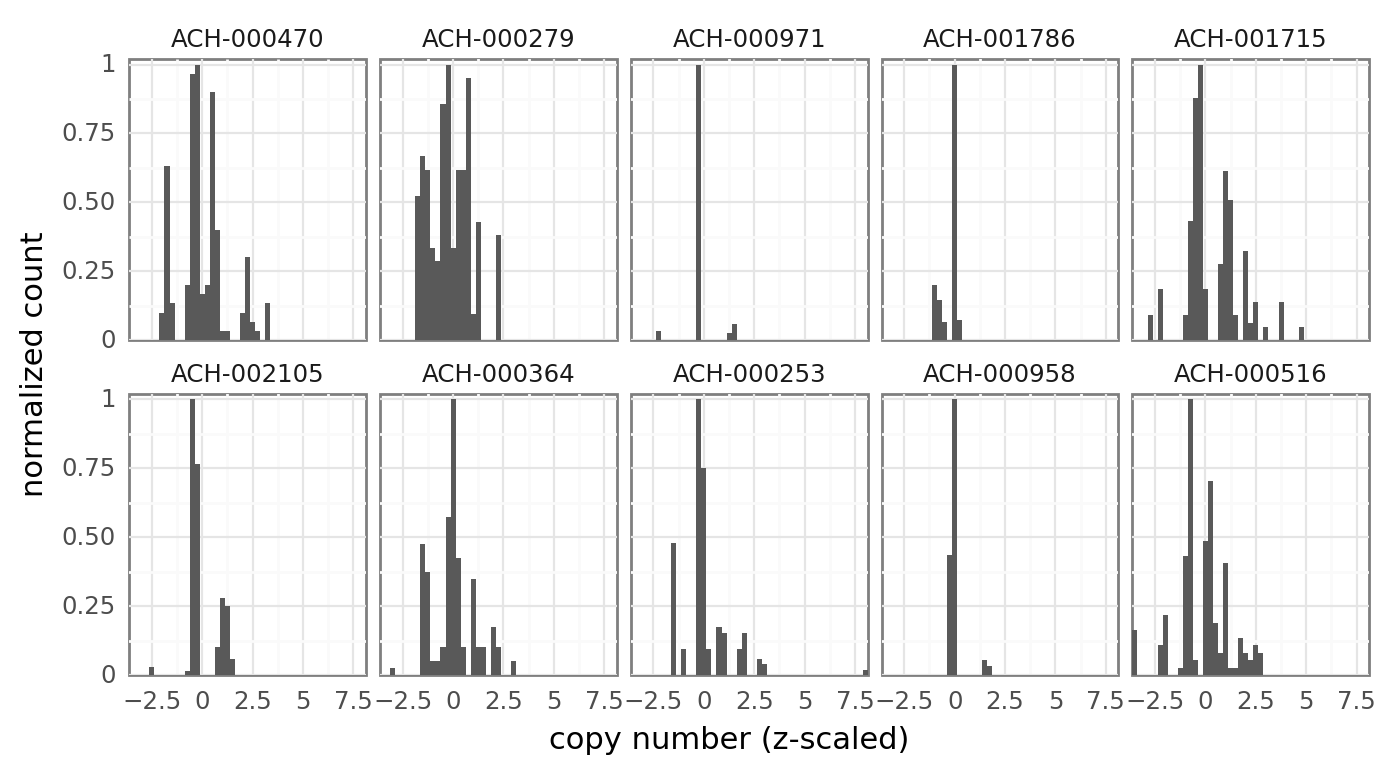

<ggplot: (361167866)>

In [39]:
(
    gg.ggplot(data, gg.aes(x="z_copy_number"))
    + gg.facet_wrap("~ depmap_id", nrow=2)
    + gg.geom_histogram(gg.aes(y=gg.after_stat("ncount")), binwidth=0.25)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.theme(figure_size=(8, 4))
    + gg.labs(x="copy number (z-scaled)", y="normalized count")
)

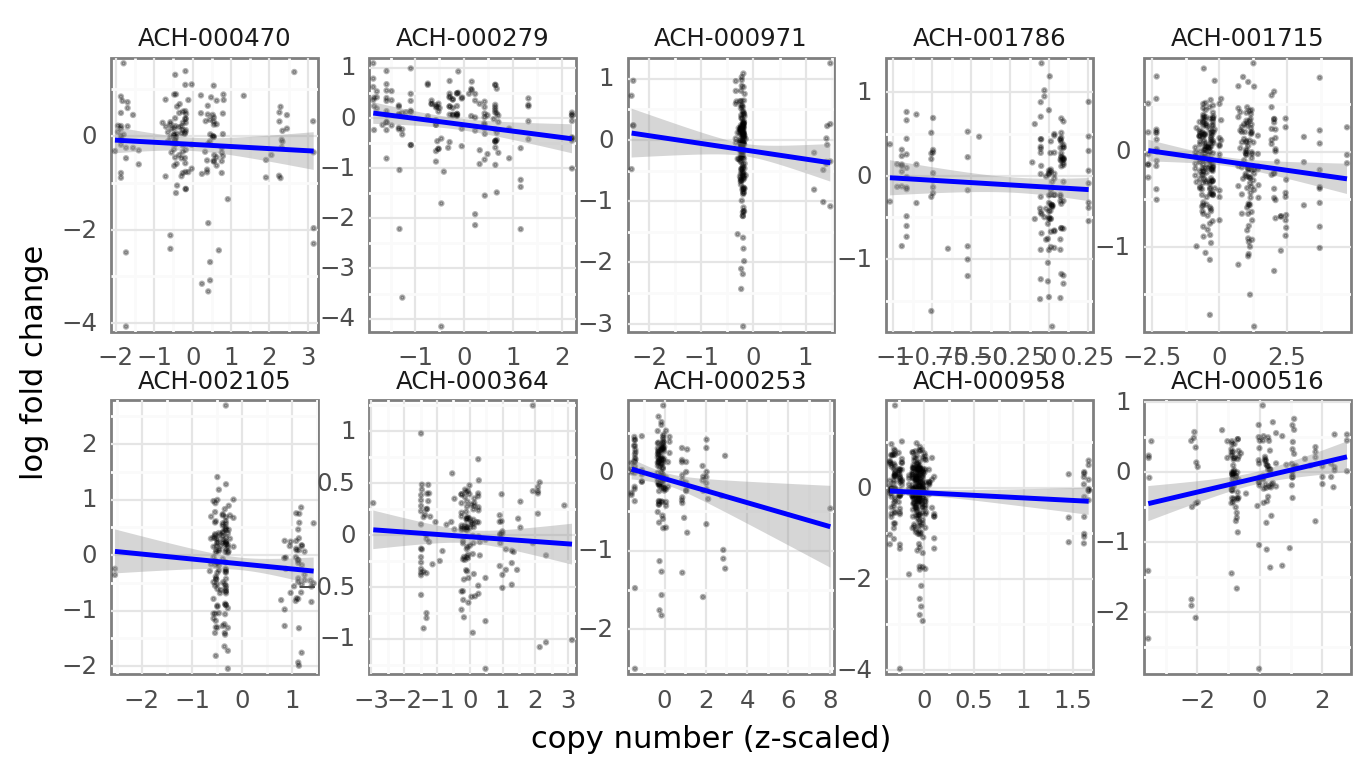

<ggplot: (375258353)>

In [66]:
(
    gg.ggplot(data, gg.aes(x="z_copy_number", y="lfc"))
    + gg.facet_wrap("~ depmap_id", nrow=2, scales="free")
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_smooth(formula="y ~ x", method="lm", color="blue")
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_x_continuous(expand=(0.02, 0))
    + gg.theme(figure_size=(8, 4), subplots_adjust={"wspace": 0.25, "hspace": 0.25})
    + gg.labs(x="copy number (z-scaled)", y="log fold change")
)

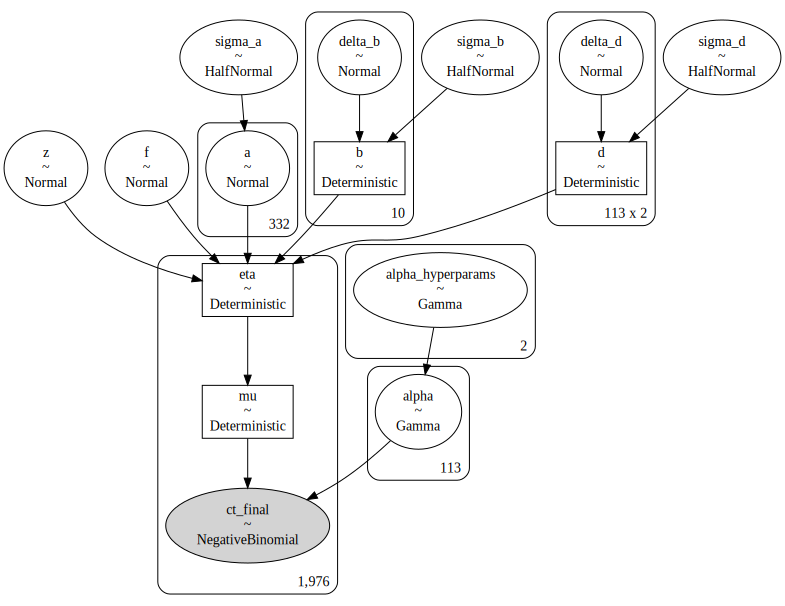

In [53]:
hnb_model = hnb.pymc3_model(data=counts_data)
pm.model_to_graphviz(hnb_model)

In [68]:
with hnb_model:
    hnb_trace = pm.sample(
        chains=4,
        cores=4,
        random_seed=329,
        target_accept=0.9,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, alpha_hyperparams, f, delta_d, sigma_d, delta_b, sigma_b, a, sigma_a, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 302 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


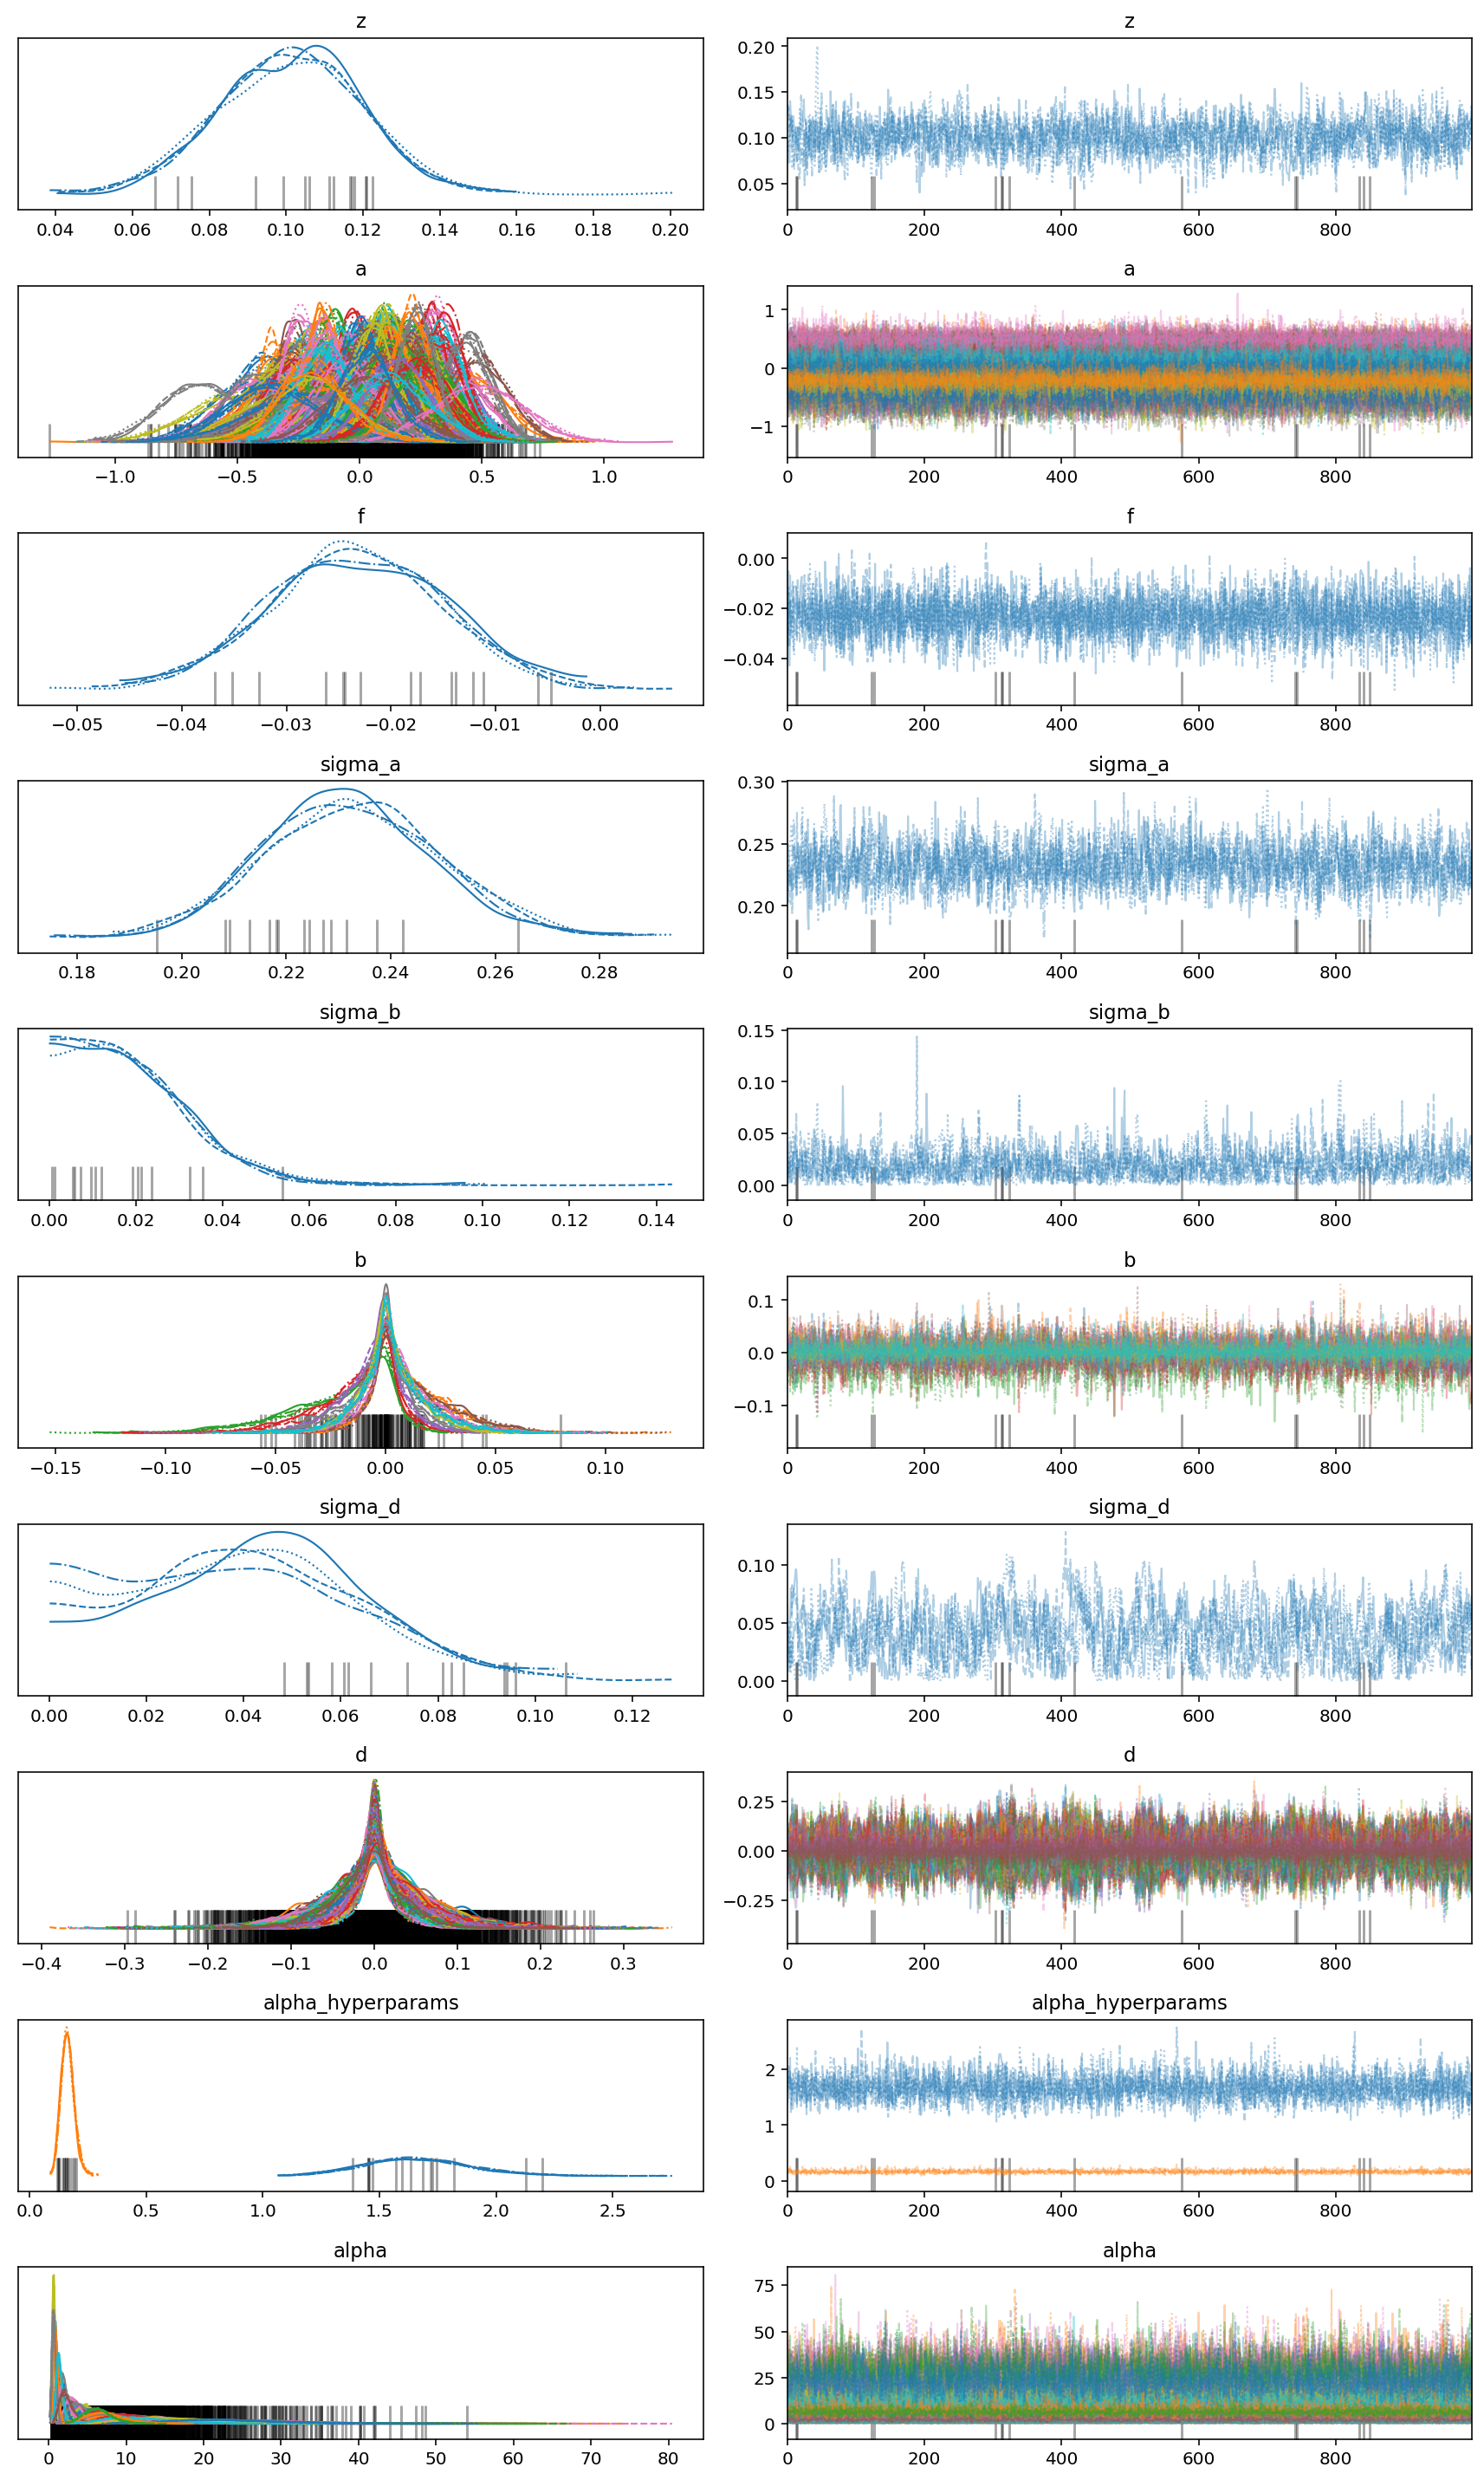

In [69]:
az.plot_trace(
    hnb_trace,
    var_names=hnb.vars_regex(fit_method=ModelFitMethod.PYMC3_MCMC),
    filter_vars="regex",
)
plt.tight_layout();

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m